# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 1. Часть 1: автоматическое дифференцирование.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит реализовать свой фреймворк для обучения нейронных сетей на основе `numpy`. Интерфейс фреймворка будет максимально копировать PyTorch, так что вы немного познакомитесь с тем, как все устроено изнутри. Директория `modules` содержит файлы с шаблонами фреймровка, а `tests` &mdash; тесты для проверки корректности ваших реализаций.

Ячейка ниже повзоляет переподгружать питоновские модули, которые вы изменили после импорта, без необходимости перезапускать ноубук.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import tests

## 0. Автоматическое дифференцирование

Самый главным объектом в нашем фреймворке будет абстракция слоя (класс `Module`), которая реализована в файле `modules/base.py`. Перед тем как писать свой код, ознакомьтесь с реализацией класса `Module`. Каждый слой должен поддерживать две операции: проход вперед, который принимает выход предыдущего слоя и вычисляет функцию слоя, и проход назад, который принимает выход предыдущего слоя и производную по своему выходу, а возвращает производную по входу, попутно обновляя градиент по своим параметрам. Вспомним общую схему еще раз. Пусть $f(x, w)$ &mdash; это наша функция слоя, которая зависит от входа $x$ и параметров в $w$, $\ell$ - функция потерь, градиент по параметрам которой нас интересует. Тогда:

- Проход вперед:

$$y = f(x, w)$$

- Проход назад:

$$\frac{d\ell}{dx} = \frac{d\ell}{dy} \cdot \frac{df(x, w)}{dx}$$

$$\frac{d\ell}{dw} = \frac{d\ell}{dy} \cdot \frac{df(x, w)}{dw}$$

Таким образом, при проходе вперед в слой передается $x$, при проходе назад $x$ и $\frac{d\ell}{dy}$. Кроме того, каждый слой сохраняет свой выход при проходе вперед, чтобы затем передать его в следующий слой при проходе назад. Сответственно, базовый класс `Module` реализует функции `forward` (или его alias, метод `__call__`, аналогично тому, как это сделано в PyTorch) и `backward`. Кроме того, шаблоны содержат некоторые служебные функции, в том числе `train` и `eval`, которые меняют режим слоя. Все слои, которые вам нужно реализовать, будут наследоваться от класса `Module`. В них потребуется реализовать методы `compute_output`, `compute_grad_input` и `update_grad_parameters` (если у слоя есть обучаемые параметры). За подробностями обращайтесь к док-строкам в шаблонах. Мы будем реализовывать слои аналогично соответствующим слоям из PyTorch, поэтому можете сверяться с документацией для уточнения значений параметров слоев. Для вашего удобства мы приводим тесты для отладки реализаций, ваше решение должно их проходить (баллы начисляются за пройденные тесты). В случае возникновения затруднений советуем дебажить код, сравнивая вашу реализацию с модулями из PyTorch.

**Важно:** мы хотим получить такое же поведение, как у PyTorch, поэтому если сделать несколько проходов назад без вызова функции `zero_grad`, то градиенты со всех проходов назад должны суммироваться. Это значит, что в функции `update_grad_parameters` нужно прибавить новый градиент к уже имеющемуся, а не перезаписать его.

Обратите внимание, что все ваши подсчеты функций и градиентов должны быть **векторизованными**, то есть включать только операции на `numpy`/`scipy` и **никаких питоновских циклов** (или оберток над ними из указанных библиотек). Специальные места, в которых циклы разрешены, будут указаны отдельно.

## 1. Линейный слой (1 балл)

- Прототип: [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- Расположение: `modules.layers.Linear`

Отныне мы будем иметь в виду, что вход нейросети $x$ имеет размер $B \times N$, где $B$ &mdash; размер мини-батча, а $N$ &mdash; размерность. Функция слоя выглядит как:

$$
y = x \, W^T + b,
$$

где $W \in \mathbb{R}^{M \times N}, b \in \mathbb{R}^M$. Таким образом, выход слоя имеет размер $B \times M$.

In [9]:
tests.test_linear()

test_linear ... OK


## 2. Batch-нормализация (2.5 балла)

- Прототип: [nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d)
- Расположение: `modules.layers.BatchNormalization`

Batch-нормализация &mdash; первый слой, который работает по-разному в train и eval режимах.

**Режим train:**

1. Для каждой координаты входа считаем статистики по мини-батчу ($x_i \in \mathbb{R}^N$ &mdash; один объект в мини-батче):

$$
\mu = \frac{1}{B} \sum_{i=1}^B x_i, \quad\quad \mu \in \mathbb{R}^N \\
\sigma^2 = \frac{1}{B} \sum_{i=1}^B (x_i - \mu)^2, \quad\quad \sigma^2 \in \mathbb{R}^N
$$

Обратите внимание, что здесь используется **смещенная** оценка дисперсии (то есть мы делим сумму квадратов отклонений на $B$, а не на $B-1$).

2. Нормируем вход с учетом статистик:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \varepsilon}}
$$

3. Применяем афинное преобразование к нормированному входу (если `affine = True`), умножение поэлементное. Это и будет выход слоя.

$$
y_i = \hat{x}_i * w + b, \quad\quad w, b \in \mathbb{R}^N
$$

4. Обновляем бегущие статистики слоя:

$$
\text{running mean} = (1 - \text{momentum}) \cdot \text{running mean} + \text{momentum} \cdot \mu \\
\text{running var} = (1 - \text{momentum}) \cdot \text{running var} + \text{momentum} \cdot \frac{B}{B - 1}
\cdot \sigma^2
$$

Здесь перенормировка $\sigma^2$ необходима, чтобы обновлять бегущую дисперсию **несмещенной** оценкой (точно так же это реализовано в PyTorch).

К параметрам слоя, которые обновляются градиентом, относятся только $w$ (`weight`) и $b$ (`bias`), но не `running_mean` и `running_var`.

**Режим eval:**

1. Нормируем вход, используя бегущие статистики:

$$
\hat{x}_i = \frac{x_i - \text{running mean}}{\sqrt{\text{running var} + \varepsilon}}
$$

2. Применяем афинное преобразование к нормированному входу:

$$
y_i = \hat{x}_i * w + b
$$

**Хозяйке на заметку**

- Убедитесь, что проход назад корректно работает и для train, и для eval режимов
- Сохраняйте промежуточные вычисления при проходе вперед, чтобы переиспользовать их при проходе назад
- Весьма вероятно, что у вас не получится правильная реализация с первого раза. Не отчаивайтесь, автор задания тоже потратил не один час, пока этот модуль не заработал. Если чувствуете, что зашли в тупик, то пользоваться гуглом никто не запрещал, но не забудьте указать источники, которыми пользуетесь.

In [8]:
tests.test_bn()

test_bn ... OK


## 3. Dropout (1 балл)

- Прототип: [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
- Расположение: `modules.layers.Dropout`

Dropout &mdash; еще один слой, чье поведение различно в train и eval режимах. Поведения слоя регулируется параметром $p$ &mdash; вероятностью занулить координату входа.

**Режим train:**

Обозначим за $m$ бинарную маску, имеющую такой же размер, как вход $x$. Маска генерируется по правилу $m_{ij} \sim \text{Bernoulli}(1-p)$. При этом при каждом новом проходе вперед генерируется новая маска (то есть она не фиксирована). Функция слоя (умножение поэлементное):

$$
y = \frac{1}{1-p} m * x
$$

Нормализация на $1-p$ необходима, чтобы среднее значение нейронов входа не изменилось.

**Режим eval:**

Здесь все предельно просто: вход слоя никаких не изменяется $y=x$.

**Хозяйке на заметку**

- Убедитесь, что проход назад корректно работает и для train, и для eval режимов

In [7]:
tests.test_dropout()

test_dropout ... OK


## 4. Функции активации (1.5 балла)

### ReLU

- Прототип: [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Расположение: `modules.activations.ReLU`

Функция слоя:

$$
y = \max(x, 0)
$$

### Sigmoid

- Прототип: [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html?highlight=nn%20sigmoid#torch.nn.Sigmoid)
- Расположение: `modules.activations.Sigmoid`

Функция слоя:

$$
y = \frac{1}{1 + e^{-x}}
$$

### Softmax

- Прототип: [nn.Softmax](http://bit.ly/get3a)
- Расположение: `modules.activations.Softmax`

Функция слоя:

$$
y_{ij} = \frac{\exp(x_{ij})}{\sum_{k=1}^{N} \exp(x_{ik})}
$$

### LogSoftmax

- Прототип: [nn.LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html?highlight=log%20softmax#torch.nn.LogSoftmax)
- Расположение: `modules.activations.LogSoftmax`

Функция слоя:

$$
y_{ij} = \log \left(\frac{\exp(x_{ij})}{\sum_{k=1}^{N} \exp(x_{ik})}\right)
$$

**Хозяйке на заметку**

- Пользуйтесь функциями из `scipy.special`
- Реализовывать `LogSoftmax` как логарифм от модуля `Softmax` &mdash; плохая идея

In [6]:
tests.test_activations()

test_activations ... OK


## 5. Контейнер Sequential (1 балл)

- Прототип: [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
- Расположение: `modules.layers.Sequential`

Контейнер-обертка, который применяет слои последовательно.

**Важно:** здесь разрешен цикл по модулям при проходах вперед и назад.

In [5]:
tests.test_sequential()

test_sequential ... OK


## 6. Функции потерь (1 балл)

Функции потерь отличаются от всех остальных модулей тем, что являются стоком вычислительного графа (то есть из них нет исходящих операций). Это означает, что с них начинается проход назад, поэтому интерфейс функции `compute_grad_input` выглядит иначе: вместо входа модуля и производной по выходу в функцию приходит предсказание нейронной сети (производная по которому нас и интересует, чтобы запустить проход назад) и целевая переменная. Базовый класс для всех функций потерь &mdash; `modules.base.Criterion`.

### MSE

- Прототип: [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
- Расположение: `modules.criterions.MSELoss`

Пусть $f \in \mathbb{R}^{B\times N}$ &mdash; предсказание нейронной сети, а $y \in \mathbb{R}^{B\times N}$ &mdash; целевая переменная. Функция потерь выглядит как:

$$
\ell(f, y) = \frac{1}{BN} \sum_{i=1}^B \sum_{j=1}^N (f_{ij} - y_{ij})^2
$$

### Cross Entropy

- Прототип: [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- Расположение: `modules.criterions.CrossEntropyLoss`

Кросс-энтропия &mdash; это функция потерь для обучения классификаторов. Пусть $f \in \mathbb{R}^{B\times C}$ (где $C$ &mdash; число классов) &mdash; предсказание нейронной сети (это так называемые *логиты*, обычно выходы линейного слоя без активации, потому могут быть любыми вещественными числами), а $y \in \{1, \dots, C\}^B$ &mdash; целевая переменная (номер класса соответствующего объекта). Функция потерь вычисляется как:

$$
p_{ic} = \frac{\exp(f_{ic})}{\sum_{k=1}^C \exp(f_{ik})}
$$

$$
\ell(f, y) = -\frac{1}{B} \sum_{i=1}^B \sum_{c=1}^C [c = y_i] \log p_{ic}
$$

При этом, $p_{ic}$ &mdash; это вероятность класса $с$ для объекта $i$, которую предсказывает нейронная сеть.

**Важно:** вычисление Softmax, а затем логарифма от него &mdash; численно нестабильная операция. Воспользуйтесь слоем LogSoftmax.

In [4]:
tests.test_criterions()

test_criterions ... OK


## 7. Оптимизаторы (1.5 балла)

Оптимизатор &mdash; вспомогательный класс, который обновляет веса нейронной сети при градиентном спуске, используя сохраненные градиенты параметров. Базовый класс &mdash; `modules.base.Optimizer`. В документации PyTorch приведен псевдокод с описанием алгоритмов, советуем обратиться туда.

**Важно:** здесь разрешен цикл по параметрам и градиентам (см. шаблоны)

### SGD

- Прототип: [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
- Расположение: `modules.optimizers.SGD`

### Adam

- Прототип: [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- Расположение: `modules.optimizers.Adam`


In [3]:
tests.test_optimizers()

test_optimizers ... OK


## 8. DataLoader (0.5 балла)

- Прототип: [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
- Расположение: `modules.dataloader.DataLoader`

И последнее, что нам осталось реализовать &mdash; это DataLoader, который перемешивает данные раз в эпоху (если это необходимо) и формирует из них мини-батчи. Технически, это будет питоновский итератор. Вот краткое [руководство](https://stackoverflow.com/questions/19151/how-to-build-a-basic-iterator), как написать итератор.

Обратите внимание, что ваша реализация должна уметь работать как с одномерным массивом целевой переменной (с формой `(num_samples, )` &mdash; так будет удобнее учить нейронную сеть на кросс-энтропию), так и с двумерной версией (с формой`(num_samples, 1)` &mdash; сответственно, на MSE).

In [2]:
tests.test_dataloader()

test_dataloader ... OK


## Собираем все вместе

Если вы все сделали правильно, то следующий кусок кода с обучением нейронной сети должен заработать.

In [25]:
import numpy as np
import modules as mm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)
X_train = np.random.randn(2048, 8)
X_test = np.random.randn(512, 8)
y_train = np.sin(X_train).sum(axis=1, keepdims=True)
y_test = np.sin(X_test).sum(axis=1, keepdims=True)

train_loader = mm.DataLoader(X_train, y_train, batch_size=64, shuffle=True)
test_loader = mm.DataLoader(X_test, y_test, batch_size=64, shuffle=False)

model = mm.Sequential(
    mm.Linear(8, 32),
    mm.BatchNormalization(32),
    mm.ReLU(),
    mm.Linear(32, 64),
    mm.Dropout(0.25),
    mm.Sigmoid(),
    mm.Linear(64, 1)
)
optimizer = mm.Adam(model, lr=1e-3)
criterion = mm.MSELoss()

In [31]:
num_epochs = 500
pbar = tqdm(range(1, num_epochs + 1))

train_losses = []
test_losses = []

for epoch in pbar:
    train_loss, test_loss = 0.0, 0.0

    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()

        train_loss += loss * X_batch.shape[0]

    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss * X_batch.shape[0]

    train_loss /= train_loader.num_samples()
    test_loss /= test_loader.num_samples()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss})

  0%|          | 0/500 [00:00<?, ?it/s]

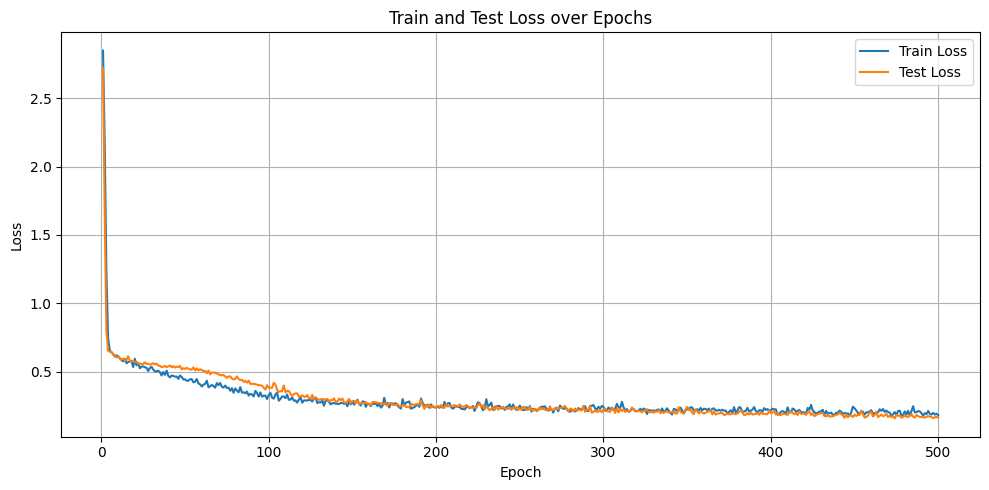

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()